<a href="https://colab.research.google.com/github/hou1020/COMP0088/blob/main/comp88_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP0088 Lab Assignment 3



## Introduction

In this week's lab assignment we look at some non-parametric classification models and ensembles. These models have losses that are not smooth and aren't suited to simple gradient-based optimisation. You are only asked to produce naïve, brute force implementations of these models, but do note that such implementations can scale really badly, so be cautious about running the algorithms with large sample sizes. You may find it interesting to think about what strategies could be used to speed things up.

Examples of the kinds of plots that will be produced by your finished code are shown below. Plotting code is provided, so your plots should look pretty similar, but the default resolution is lower to avoid the code taking too long to run.

![example of completed plots](https://comp0088.github.io/assets/colab/week_3_small.jpg)

The notebook uses a synthetic dataset (`week_3_data.csv`), which will be downloaded from the module GitHub in the **Setting Up** section below. This includes both binary and 3-class labels for the same data points, as illustrated in the following plots.

![plots of data with binary and three-class labels](https://comp0088.github.io/assets/colab/week_3_data_small.jpg)

## Setting Up

As usual, this notebook makes use of the NumPy library for numerical computing and the Matplotlib library for plotting, so we need to import them. We will also use the [Pandas](https://pandas.pydata.org/docs/user_guide/index.html) library for loading data.

In [1]:
import numpy as np
import numpy.random
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# this is probably the default, but just in case
%matplotlib inline

We'll also fetch some shared COMP0088 lab code and data from the module GitHub:

In [2]:
# load lab code and resources
!git clone https://github.com/comp0088/shared.git comp0088

# at the moment this is all we care about
import comp0088.utils as utils

Cloning into 'comp0088'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 3), reused 11 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 11.54 KiB | 11.54 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Set up some items for later use. We just load the whole dataset here — later on we'll access particular subsets of it.

In [3]:
# finally, set up some items for use in later code
shared_rng = numpy.random.default_rng()

# load the synthetic data
df = pd.read_csv('comp0088/week_3_data.csv')

# Task 1: $k$-Nearest Neighbours

In a $k$-Nearest Neighbours classifier, test samples are compared directly against the samples in the training set and the $k$ most similar (according to some chosen similarity or distance metric) vote on the class to predict. Training such a classifier consists simply of memorising the training set. For the implementation below, we will skip this step and just pass the training data directly to the prediction function.

Although other distance metrics may be useful for real problem classes, for the purposes of this exercise you can stick to a simple Euclidean distance. The NumPy function [`numpy.linalg.norm`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html) is one way to calculate this.

You may find the function `vote` in the `utils` module useful.

## 1.1 Implement $k$-Nearest Neighbours prediction

Implement the body of the `nearest_neighbours_predict` function in the cell below.


In [7]:
def nearest_neighbours_predict ( train_X, train_y, test_X, neighbours=1 ):
    """
    Predict labels for test data based on neighbourhood in
    training set.

    # Arguments:
        train_X: an array of sample data for training, where rows
            are samples and columns are features.
        train_y: vector of class labels corresponding to the training
            samples, must be same length as number of rows in X
        test_X: an array of sample data to generate predictions for,
            in same layout as train_X.
        neighbours: how many neighbours to canvass at each test point

    # Returns
        test_y: predicted labels for the samples in test_X
    """
    assert(train_X.shape[0] == train_y.shape[0])
    assert(train_X.shape[1] == test_X.shape[1])

    # TODO: implement the k-nearest neighbours algorithm
    test_y = []

    for test_point in test_X:
        # 计算测试点到所有训练点的欧氏距离
        distances = np.linalg.norm(train_X - test_point, axis=1)

        # 找到最近 neighbours 个点的索引
        nearest_indices = np.argsort(distances)[:neighbours]

        # 取出最近 neighbours 个点的标签
        nearest_labels = train_y[nearest_indices]

        # 多数投票
        predicted_label = utils.vote(nearest_labels)
        test_y.append(predicted_label)

    return np.array(test_y)

## → Run Task 1

Execute the code cell below to run your k-NN function on the test data and plot the results.

Feel free to try out different values for the configuration variables `NUM_SAMPLES`, `RESOLUTION` and `NEIGHBOURS` -- but note that larger values can slow things down significantly.

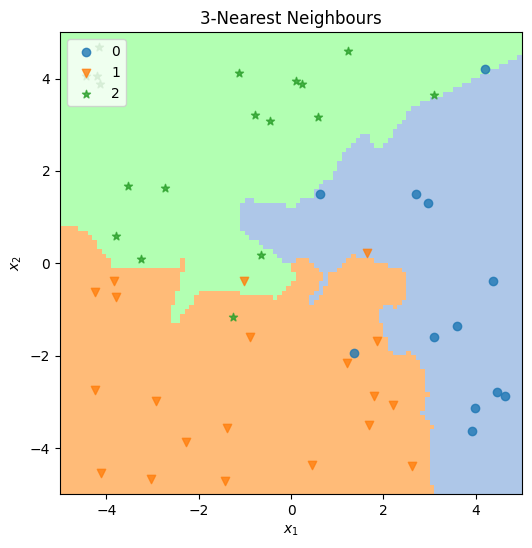

In [8]:
NUM_SAMPLES = 50
RESOLUTION = 100
NEIGHBOURS = 3

X = df[['X1','X2']].values[:NUM_SAMPLES,:]
y = df['Multi'].values[:NUM_SAMPLES]

fig = plt.figure(figsize=(6, 6))
ax = fig.subplots()

# this just tests to see whether there's a functioning implementation
# before attempting to pass it to the plotting utility
dummy = nearest_neighbours_predict ( X[:2,:], y[:2], X[:2,:], neighbours=NEIGHBOURS )
if dummy is None:
    utils.plot_unimplemented(ax, f'{NEIGHBOURS}-Nearest Neighbours')
else:
    nn_cls = lambda z: nearest_neighbours_predict ( X, y, z, neighbours=NEIGHBOURS )
    utils.plot_classification_map(ax, nn_cls, X, y, resolution=RESOLUTION, title=f'{NEIGHBOURS}-Nearest Neighbours')


# Task 2: Decision Trees

Decision trees are both a learning model in their own right and an important constituent model for the ensemble methods in subsequent tasks. The model consists of a recursive sequence of binary tests, typically of inequalities on single feature values. These effectively partition the feature space into separate regions, each of which is then assigned the class that occurs most often among training samples within it.(Equivalently, those training samples *vote* on the outcome. Once again, the `utils.vote` function may be useful here.)

Trees can be trained by a greedy brute force search for the split that minimises some chosen loss. Various losses are possible, but for simplicity here (and compatibility with Task 4 later) we will use a **weighted misclassification error** throughout:

$$
L(\mathbf{y}, \hat{\mathbf{y}}, \mathbf{w}) = \sum_i w_i \mathbb{1}(y_i \neq \hat{y}_i)
$$

Trees are a naturally recursive data structure that almost cry out for a class-based implementation, but here we limit ourselves to using dicts to avoid adding syntactical distractions for students who may not be very familiar with Python classes.

## 2.1 Calculate a weighted misclassification error

Implement the `misclassification` function in the code cell below. Note that if `weights` is not provided you should default it to $\frac{1}{n}$.


In [11]:
def misclassification ( y, cls, weights=None ):
    """
    Calculate (optionally-weighted) misclassification error for
    a given set of labels if assigned the given class.

    # Arguments
        y: a set of class labels
        cls: a candidate classification for the set
        weights: optional weights vector specifying relative
            importance of the samples labelled by y

    # Returns
        err: the misclassification error of the candidate labels
    """

    # TODO: implement weighted misclassification metric
    # 样本数
    n = len(y)

    # 如果没有提供权重，默认每个样本权重为 1/n
    if weights is None:
        weights = np.ones(n) / n

    # 计算加权 misclassification
    err = np.sum(weights[y != cls]) / np.sum(weights)

    return err

## 2.2 Split a dataset to reduce misclassification

Implement the body of the `decision_node_split` function in the cell below. This function is quite involved and there are some finicky details, so read the docstring carefully.

Some things to note:
* It's a **brute force** search. Yes, this will scale badly and may also offend your coding sensibilities; just go with it.
* The total loss after a split must be scaled according to the samples in each child node. You should be able to use the `weights` argument to help with this.
* You need to decide on some tie-break policy for when multiple splits produce the same loss improvement.
* The return values from this function are effectively **instructions** on how to split. You don't return the actual child node data.

In [12]:
def decision_node_split ( X, y, cls=None, weights=None, min_size=3 ):
    """
    Find (by brute force) a split point that best improves the weighted
    misclassification error rate compared to the original one (or not, if
    there is no improvement possible).

    Features are assumed to be numeric and the test condition is
    greater-or-equal.

    # Arguments:
        X: an array of sample data, where rows are samples
            and columns are features.
        y: vector of class labels corresponding to the samples,
            must be same length as number of rows in X
        cls: class label currently assigned to the whole set
            (if not specified we use the most common class in y, or
            the lowest such if 2 or more classes occur equally)
        weights: optional weights vector specifying relevant importance
            of the samples
        min_size: don't create child nodes smaller than this

    # Returns:
        feature: index of the feature to test (or None, if no split)
        thresh: value of the feature to test (or None, if no split)
        c0: class assigned to the set with feature < thresh (or None, if no split)
        c1: class assigned to the set with feature >= thresh (or None, if no split)
    """
    assert(X.shape[0] == len(y))

    # TODO: implement this
    n_samples, n_features = X.shape
    y = np.array(y)
    weights = np.ones(n_samples) / n_samples if weights is None else np.array(weights)

    # 确定当前整集合的类别
    if cls is None:
        unique, counts = np.unique(y, return_counts=True)
        max_count = np.max(counts)
        cls_candidates = unique[counts == max_count]
        cls = np.min(cls_candidates)  # 平局取最小类别

    # 当前整集合加权误差
    best_err = misclassification(y, cls, weights)
    best_feature, best_thresh, best_c0, best_c1 = None, None, None, None

    # 遍历每个特征
    for f in range(n_features):
        feature_values = np.sort(np.unique(X[:, f]))
        # 遍历相邻特征值的中点作为候选阈值
        for i in range(len(feature_values) - 1):
            thresh = (feature_values[i] + feature_values[i+1]) / 2

            # 划分左右子节点
            mask0 = X[:, f] < thresh
            mask1 = ~mask0

            # 忽略小于 min_size 的子节点
            if np.sum(mask0) < min_size or np.sum(mask1) < min_size:
                continue

            # 子节点最优类别
            def best_class(y_sub, w_sub):
                unique_labels = np.unique(y_sub)
                best_err_sub = np.inf
                best_label = None
                for candidate in unique_labels:
                    err_candidate = misclassification(y_sub, candidate, w_sub)
                    if err_candidate < best_err_sub:
                        best_err_sub = err_candidate
                        best_label = candidate
                return best_label

            c0 = best_class(y[mask0], weights[mask0])
            c1 = best_class(y[mask1], weights[mask1])

            # 加权总误差
            total_err = (np.sum(weights[mask0] * (y[mask0] != c0)) +
                         np.sum(weights[mask1] * (y[mask1] != c1))) / np.sum(weights)

            # 更新最优分割
            if total_err < best_err:
                best_err = total_err
                best_feature = f
                best_thresh = thresh
                best_c0 = c0
                best_c1 = c1
            # 平局策略：同误差优先小的特征索引或阈值
            elif total_err == best_err:
                if best_feature is None or f < best_feature or (f == best_feature and thresh < best_thresh):
                    best_feature = f
                    best_thresh = thresh
                    best_c0 = c0
                    best_c1 = c1

    return best_feature, best_thresh, best_c0, best_c1

## 2.3 Train a decision tree classifier

Implement the body of the `decision_tree_train` function in the cell below.

You should find that most of the hard work is already done by your `decision_node_split` function, and this is just responsible for managing the recursion. But doing so is also a bit finicky. Again, you should read the docstring carefully to get a handle on the returned data structure.

In [13]:
def decision_tree_train ( X, y, cls=None, weights=None, min_size=3, depth=0, max_depth=10 ):
    """
    Recursively choose split points for a training dataset
    until no further improvement occurs.

    # Arguments:
        X: an array of sample data, where rows are samples
            and columns are features.
        y: vector of class labels corresponding to the samples,
            must be same length as number of rows in X
        cls: class label currently assigned to the whole set
            (if not specified we use the most common class in y, or
            the lowest such if 2 or more classes occur equally)
        weights: optional weights vector specifying relevant importance
            of the samples
        min_size: don't create child nodes smaller than this
        depth: current recursion depth
        max_depth: maximum allowed recursion depth

    # Returns:
        tree: a dict containing (some of) the following keys:
            'kind' : either 'leaf' or 'decision'
            'class' : the class assigned to this node (for a leaf)
            'feature' : index of feature on which to split (for a decision)
            'thresh' : threshold at which to split the feature (for a decision)
            'below' : a nested tree applicable when feature < thresh
            'above' : a nested tree applicable when feature >= thresh
    """
    # TODO: implement this
    n_samples = X.shape[0]
    y = np.array(y)
    weights = np.ones(n_samples) / n_samples if weights is None else np.array(weights)

    # 当前节点类别（最常见类别，平局取最小）
    if cls is None:
        unique, counts = np.unique(y, return_counts=True)
        max_count = np.max(counts)
        cls_candidates = unique[counts == max_count]
        cls = np.min(cls_candidates)

    # 叶节点条件：达到最大深度或样本数小于最小值
    if depth >= max_depth or n_samples <= min_size:
        return {'kind': 'leaf', 'class': cls}

    # 尝试找到最佳分割点
    feature, thresh, c0, c1 = decision_node_split(X, y, cls, weights, min_size)

    # 没有找到分割 → 返回叶节点
    if feature is None:
        return {'kind': 'leaf', 'class': cls}

    # 根据分割递归生成左右子树
    mask_below = X[:, feature] < thresh
    mask_above = ~mask_below

    below_tree = decision_tree_train(
        X[mask_below], y[mask_below],
        cls=c0, weights=weights[mask_below],
        min_size=min_size, depth=depth+1, max_depth=max_depth
    )
    above_tree = decision_tree_train(
        X[mask_above], y[mask_above],
        cls=c1, weights=weights[mask_above],
        min_size=min_size, depth=depth+1, max_depth=max_depth
    )

    # 返回当前节点（决策节点）
    return {
        'kind': 'decision',
        'feature': feature,
        'thresh': thresh,
        'below': below_tree,
        'above': above_tree
    }

## 2.4 Make predictions from a decision tree

Implement the body of the `decision_tree_predict` function in the cell below. You will need to walk the tree for each sample, testing decision nodes until you reach a leaf.

You may find it helpful to define an auxiliary function to process a single sample.

In [17]:
def decision_tree_predict ( tree, X ):
    """
    Predict labels for test data using a fitted decision tree.

    # Arguments
        tree: a decision tree dictionary returned by decision_tree_train
        X: an array of sample data, where rows are samples
            and columns are features.

    # Returns
        y: the predicted labels
    """
    # TODO: implement this
    X = np.array(X)
    n_samples = X.shape[0]
    y_pred = np.empty(n_samples, dtype=int)  # 改成 int 类型

    def predict_single(node, x):
        """递归预测单个样本"""
        if node['kind'] == 'leaf':
            return node['class']
        else:
            feature = node['feature']
            thresh = node['thresh']
            if x[feature] < thresh:
                return predict_single(node['below'], x)
            else:
                return predict_single(node['above'], x)

    for i in range(n_samples):
        y_pred[i] = predict_single(tree, X[i, :])

    return y_pred

## → Run Task 2

Execute the code cell below to use your functions above to train and test a decision tree classifier and generate a plot.

As in Task 1, try playing with different values for `NUM_SAMPLES` and `RESOLUTION` and see how this affects the results — and the running time.

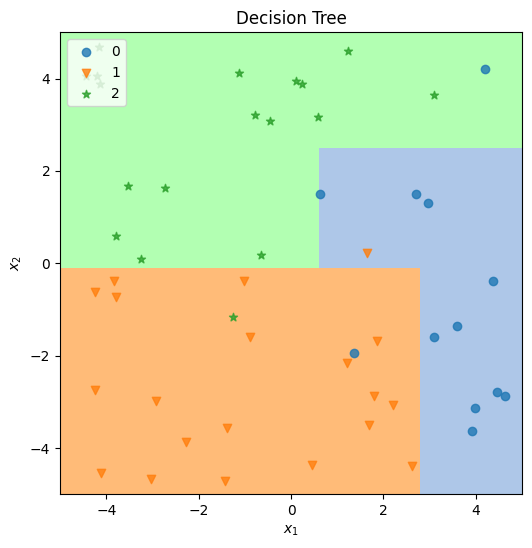

In [18]:
NUM_SAMPLES = 50
RESOLUTION = 100
MIN_SIZE = 3

X = df[['X1','X2']].values[:NUM_SAMPLES,:]
y = df['Multi'].values[:NUM_SAMPLES]

fig = plt.figure(figsize=(6, 6))
ax = fig.subplots()

tree = decision_tree_train ( X, y, min_size=MIN_SIZE )
if tree is None:
    utils.plot_unimplemented(ax, f'Decision Tree')
else:
    tree_cls = lambda z: decision_tree_predict ( tree, z )
    utils.plot_classification_map(ax, tree_cls, X, y, resolution=RESOLUTION, title=f'Decision Tree')

# Task 3: Random Forests

Random forests<sup><small>TM</small></sup> are an ensemble model aggregating the predictions from multiple decision trees. Diversity is introduced into the ensemble by training the trees on **bootstrap samples** from the training set, and also by restricting the subset of features used by each tree.

For the exercises below, we will forgo feature subsetting (we will only be using two features anyway) and focus on the **bagging** aspect.


## 3.1 Train a (simplified) random forest classifier

Implement the `random_forest_train` function in the code cell below.

Use the `decision_tree_train` function you wrote in Task 2.3 to train the individual trees. The [choice](https://numpy.org/doc/stable/reference/random/generated/numpy.random.Generator.choice.html) method of the supplied `rng` object should help with bootstrap sampling.

In [ ]:
def random_forest_train ( X, y, k, rng, min_size=3, max_depth=10 ):
    """
    Train a (simplified) random forest of decision trees.

    # Arguments:
        X: an array of sample data, where rows are samples
            and columns are features.
        y: vector of binary class labels corresponding to the
            samples, must be same length as number of rows in X
        k: the number of trees in the forest
        rng: an instance of numpy.random.Generator
            from which to draw random numbers
        min_size: don't create child nodes smaller than this
        max_depth: maximum tree depth

    # Returns:
        forest: a list of tree dicts as returned by decision_tree_train
    """

    # TODO: implement this
    return None

## 3.2 Make predictions from a (simplified) random forest classifier

Implement the `random_forest_predict` function in the cell below.

Use the `decision_tree_predict` function you wrote in Task 2.4 to predict from the individual trees.

Once again, the `utils.vote` function may be useful here.

In [ ]:
def random_forest_predict ( forest, X ):
    """
    Predict labels for test data using a fitted random
    forest of decision trees.

    # Arguments
        forest: a list of decision tree dicts
        X: an array of sample data, where rows are samples
            and columns are features.

    # Returns
        y: the predicted labels
    """
    # TODO: implement this
    return None

## → Run Task 3

Execute the cell below to train and test a simplified random forest classifier and produce a plot.



In [ ]:
NUM_SAMPLES = 50
RESOLUTION = 100
NUM_TREES = 10

X = df[['X1','X2']].values[:NUM_SAMPLES,:]
y = df['Multi'].values[:NUM_SAMPLES]

fig = plt.figure(figsize=(6, 6))
ax = fig.subplots()

forest = random_forest_train ( X, y, NUM_TREES, rng=shared_rng )
if forest is None:
    utils.plot_unimplemented(ax, f'Random Forest')
else:
    forest_cls = lambda z: random_forest_predict ( forest, z )
    utils.plot_classification_map(ax, forest_cls, X, y, resolution=RESOLUTION, title=f'Random Forest ({NUM_TREES} trees)')

# Task 4: AdaBoost

AdaBoost is a meta-algorithm that iteratively builds an ensemble of weak learners such that each new addition provides the best available marginal improvement in the ensemble performance. The new learner is chosen to minimise its weighted classification error on the training set, with the sample weights updated at each iteration to prioritise misclassified points. The training procedure is shown in pseudocode form below:


* Initialise sample weights $w_i = \frac{1}{n}, \quad i \in \{1, 2, \dots, n\}$
* **for** t = 1 to k **do**:
  * fit classifier $h_t$ to minimise misclassification error with weights $w_i$
  * set $\epsilon =$ the weighted misclassification error of $h_t$
  * compute prediction weight: $\alpha_t = \log\big(\frac{1-\epsilon}{\epsilon}\big)$
  * update weights: $w_i \leftarrow w_i \exp(\alpha_t \mathbb{1}(y_i \neq h_i(x_i)))$
  * normalise weights: $w_i = \frac{w_i}{\sum_j w_j}$

Once the ensemble is trained, new samples are classified like this:

$$
\hat{y} = \mathbb{1}\left(\sum_t \alpha_t h_t(\mathbf{x}) \ge 0\right)
$$

Note that the training algorithm has been expressed in terms that don't require a particular binary labelling convention, but the prediction expression above assumes that the outputs of the classifiers $h_t$ are $\{-1, 1\}$. This is *not* the case for the decision trees implemented in Task 2, nor for the synthetic data. So you will need to convert the $h_t$ outputs appropriately within the prediction sum.

AdaBoost is agnostic as to the class of weak learners used, but is commonly implemented using **decision stumps** — decision trees of depth 1 — and that is what you should do here, using the decision tree functions you implemented in Task 2.

## 4.1 Train an AdaBoost classifier

Provide an implementation body for the `adaboost_train` function defined in the cell below.

Once again, read the docstring carefully, as there are some fiddly details.


In [ ]:
def adaboost_train ( X, y, k, min_size=1, max_depth=1, epsilon=1e-8 ):
    """
    Iteratively train a set of decision tree classifiers
    using AdaBoost.

    # Arguments:
        X: an array of sample data, where rows are samples
            and columns are features.
        y: vector of binary class labels corresponding to the
            samples, must be same length as number of rows in X
        k: the maximum number of weak classifiers to train
        min_size: don't create child nodes smaller than this
        max_depth: maximum tree depth -- by default we just
            use decision stumps
        epsilon: threshold below which the error is considered 0

    # Returns:
        trees: a list of tree dicts as returned by decision_tree_train
        alphas: a vector of weights indicating how much credence to
            given each of the decision tree predictions
    """
    # TODO: implement this
    return None, None

## 4.2 Make predictions from an AdaBoost classifier

Implement the `adaboost_predict` function in the code cell below.

As noted above, you will need to map the decision tree predictions from $\{0, 1\}$ to $\{-1, 1\}$.

In [ ]:
def adaboost_predict ( trees, alphas, X ):
    """
    Predict labels for test data using a fitted AdaBoost
    ensemble of decision trees.

    # Arguments
        trees: a list of decision tree dicts
        alphas: a vector of weights for the trees
        X: an array of sample data, where rows are samples
            and columns are features.

    # Returns
        y: the predicted labels
    """
    # TODO: implement this
    return None

## → Run Task 4

Execute the code cell below to train and test an AdaBoost classifier and plot the results.


In [ ]:
NUM_SAMPLES = 50
RESOLUTION = 100
NUM_TREES = 10

X = df[['X1','X2']].values[:NUM_SAMPLES,:]
y = df['Binary'].values[:NUM_SAMPLES]

fig = plt.figure(figsize=(6, 6))
ax = fig.subplots()

trees, alphas = adaboost_train ( X, y, NUM_TREES )
if forest is None:
    utils.plot_unimplemented(ax, f'AdaBoost')
else:
    ada_cls = lambda z: adaboost_predict ( trees, alphas, z )
    utils.plot_classification_map(ax, ada_cls, X, y, resolution=RESOLUTION, title=f'AdaBoost ({NUM_TREES} stumps)')

# Further exploration

If you have exhausted the previous exercises, you might find it interesting to try out one or more of the following challenges. Doing so is entirely optional, but may provide some additional perspective that could be useful in the weeks ahead.

## Adapt your decision trees to use a different loss

The decision trees for Task 2 use a weighted misclassification error in order to easily use them with AdaBoost. However, other loss functions may be preferable for some problems. Two common choices are the Gini impurity:

\begin{equation}
\sum_k p_k (1 - p_k)
\end{equation}

and the entropy (or cross-entropy):

\begin{equation}
- \sum_k p_k \log p_k
\end{equation}

where $k$ ranges over all the classes present in the node and $p_k$ is the fraction of samples in the node that are of class $k$.

Try modifying your implementation to use one or both of these losses and see what difference (if any) it makes to the splits chosen and the performance of the trees. (There is an implementation of `gini_impurity` in the `utils` module.)


## Add feature subset selection to your random forests

For simplicity in Task 3 we omitted feature subsetting as a diversification mechanism in the ensemble. Try adding this and seeing if it makes much difference to your fits. You will need to adapt the data structure used for the forest to keep track of which trees are using which features so that the correct subsets can be used at test time.

You may want to find some higher-dimensional data to apply your modified algorithm to, as the supplied data---having only two features---doesn't provide very much scope for variation. As mentioned last week, the [`scikit-learn` datasets](https://scikit-learn.org/stable/datasets.html) package can be a good source of data to play with.


## Implement an ExtraTrees ensemble

Bagging and feature subsetting are not the only way to build a diverse ensemble of decision trees. In the ExtraTrees or **extremely randomised trees** approach, the training algorithm for the trees is modified instead. At each split point, rather than performing a brute force search over all possible splits, a random search is used instead: some specified (but relatively small) number of purely random candidate splits are evaluated, and the best of these is chosen. This can result in a high degree of variation in the ensemble that *may* better probe the structure of the data distribution.

Try implementing this fitting procedure and comparing its behaviour to that of the random forest. Is there any meaningful difference for our simple data?


## Compare the behaviour of these models in `scikit-learn`

For practical applications, you will almost never need to implement classic ML models like decision trees and random forests yourself. Instead, you will typically use existing implementations such as those in the [`scikit-learn`](https://scikit-learn.org/stable/index.html) library. Because they are so widely used, these are likely to be more versatile, better optimised and better tested than your own code.

`scikit-learn` supports a wide range of ML models and algorithms, including all those in the lab exercises above: [nearest neighbours](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification), [decision trees](https://scikit-learn.org/stable/modules/tree.html), [AdaBoost](https://scikit-learn.org/stable/modules/ensemble.html#adaboost) and [forests of randomised trees](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees). Models have (mostly) consistent interfaces for training and evaluation, so it is usually straightforward to swap between different models and compare their behaviour.

We will see a bit more of this library in future weeks, but by all means get acquainted with it now if you have the time and inclination.